# Exploratory Data Analysis

(To run this notebook successfully, one needs to install the "neurokit2" and "biobss" packages for biosignal processings and feature extractions)

### Load and Explore a CSV file


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

#sns.set_style('whitegrid')

There are 17 ".csv" data files from 17 participants with the following code names. As will be clear that  the index-5 participant '93JD' and the index-16 participant 'ME93' do not contain all the signal modalitis like other participants. We therefore discard data from these two participants. 

In [2]:
participant_codes = ['3B8D','03FH','3RFH','4JF9','93DK','93JD','AP3H','F408',
                     'H39D','JD3K','K2Q2','KF93','KS03','LAS2','LDM5','LK27','ME93']

#discarding "93JD" and "ME93"

selected_participants = ['3B8D','03FH','3RFH','4JF9','93DK','AP3H','F408',
                     'H39D','JD3K','K2Q2','KF93','KS03','LAS2','LDM5','LK27']

#### Reading data from one of the participants: '3B8D':

In [42]:
code = selected_participants[0]
signals = pd.read_csv(f'csv/{code}.csv', index_col=0, parse_dates=True, low_memory=False)
signals.head(5)

,ecg:dry,ecg:gel,eda:dry,eda:gel,emg:Left Bicep,temp:temp,ppg:Left index finger,ppg:Left Wrist,acc_e4:z,acc_e4:x,acc_e4:y,acc_chest:x,acc_chest:y,acc_chest:z,activities
2000-01-01 00:00:00.000,NaN,NaN,-0.000005,NaN,NaN,33.290005,NaN,0.000031,0.968750,-0.296875,0.031250,NaN,NaN,NaN,NaN
2000-01-01 00:00:00.002,NaN,NaN,-0.009847,NaN,NaN,33.315048,NaN,4.088831,0.977965,-0.288245,0.053558,NaN,NaN,NaN,NaN
2000-01-01 00:00:00.004,NaN,NaN,-0.019340,NaN,NaN,33.339577,NaN,6.657014,0.985778,-0.280033,0.071925,NaN,NaN,NaN,NaN
2000-01-01 00:00:00.006,NaN,NaN,-0.028484,NaN,NaN,33.363640,NaN,7.731560,0.992168,-0.272339,0.086317,NaN,NaN,NaN,NaN
2000-01-01 00:00:00.008,NaN,NaN,-0.037268,NaN,NaN,33.387218,NaN,7.478426,0.997149,-0.265248,0.096787,NaN,NaN,NaN,NaN


#### There are 14 biosignals recorded for each participant.
* ecg:dry 
* ecg:gel
* eda:dry
* eda:gel
* emg:Left Bicep
* temp:temp
* ppg:Left index finger
* ppg:Left Wrist
* acc_e4:z
* acc_e4:x
* acc_e4:y
* acc_chest:x
* acc_chest:y
* acc_chest:z

In [43]:
cols = signals.columns.values
cols

array(['ecg:dry', 'ecg:gel', 'eda:dry', 'eda:gel', 'emg:Left Bicep',
       'temp:temp', 'ppg:Left index finger', 'ppg:Left Wrist', 'acc_e4:z',
       'acc_e4:x', 'acc_e4:y', 'acc_chest:x', 'acc_chest:y',
       'acc_chest:z', 'activities'], dtype=object)

#### There are 8 activities. But not all participants perform all the 8 activities.
* baseline
* lift
* greetings
* gesticulates
* jumps
* walk_before
* run
* walk_after

In [44]:
signals_copy  = signals.copy()

act_column = signals_copy['activities'].unique()
act_column

array([nan, 'baseline,', 'lift,', 'greetings,', 'gesticulate,',
       'walk_before,', 'run,', 'walk_after,'], dtype=object)

As one can see, there are a lot of missing values (nan) not only in the biosignals but also in the activity column.
Our strategy to deal with missing values is to drop all the rows that contain missing values.

In [45]:
#droping any rows containing NaN

before_len = len(signals_copy)

signals_copy.dropna(inplace=True)

after_len = len(signals_copy)
print("signal size reduces after dropping NaN from ", before_len, " to ", after_len, " survival ratio ", after_len/before_len*100)

signal size reduces after dropping NaN from  1906007  to  1196708  survival ratio  62.78612827759814


#### Our goal is to use recorded biosignals to predict human activities. 

We encode the different activities using integer from 1 to 8.

In [46]:
all_columns = signals_copy.columns.values
all_channels = all_columns[:-1]

In [47]:
activity_encoder = {'baseline,':1,'lift,':2,'lift-1,':2, 'lift-2,':2,
                    'greetings,':3, 
                    'gesticulate,':4, 'jumps,':5, 
                    'walk_before,':6,'walk_before_downstairs,':6,'walk_before_elevatorup,':6,'walk_before_elevatordown,':6,
                    'run,':7, 'sprint,run,':7,
                    'walk_after,':8, 'run,walk_after':8, 'run,walk_after,':8}

In [48]:
signals_copy['activities'] = signals_copy['activities'].replace(activity_encoder)
signals_copy['activities']=pd.to_numeric(signals_copy['activities'])


activity_num=signals_copy['activities'].unique()
activity_num

array([1, 2, 3, 4, 6, 7, 8])

To find out the onset and duration of each activity in the whole time series, we use the "neurokit2" package.
The "events_find()" function detects the onset of different activities.

In [49]:
import neurokit2 as nk

In [50]:
for i in range(1,9):
    if i in signals_copy['activities'].unique():
        change_row = signals_copy.loc[signals_copy['activities']==i].index[0]
        signals_copy.loc[change_row, 'activities']=0

In [51]:

events = nk.events_find(event_channel=signals_copy['activities'], 
                        threshold = 0,
                        threshold_keep='above', 
                        event_conditions=activity_num)

events


{'onset': array([      1,   30071,   55914,   75649,  124926,  274472, 1033267]),
 'duration': array([ 30069,  25842,  19734,  49276, 149545, 758794, 163441]),
 'label': array(['1', '2', '3', '4', '5', '6', '7'], dtype='<U21'),
 'condition': array([1, 2, 3, 4, 6, 7, 8])}

# 1. ECG

An electrocardiogram (ECG) signal is a bioelectrical signal that measures the electrical activity of the heart's muscle cells. ECG signals are made up of P-waves, QRS complexes, and T-waves, and are used to track heart rhythm and cardiac diseases

We explore the "ecg:dry" and "ecg:gel" biosignals.

The frequency of data taking is 500Hz, which means 500 consecutive data points represent one second. As shown in the above figures on temperature, the whole data taking process for each participant lasts about 60 minutes. 
In the following, we use a window of 10 seconds to explore the signals.

In [13]:
fs = 500
n_timepoints = fs*10

We will use the "biobss" package and the "neurokit2" package for biosignal data analysis. 

https://github.com/obss/BIOBSS

https://github.com/neuropsychology/NeuroKit

In [14]:
import biobss

/Users/mingli/Documents/anaconda3/lib/python3.11/site-packages/plotly_resampler-0.8.2-py3.11.egg/plotly_resampler/aggregation/aggregators.py:24: UserWarning: Could not import lttbc; will use a (slower) python alternative.


In [15]:
ecg_dry = signals_copy.iloc[events['onset'][4] + n_timepoints*(1-1): events['onset'][4]+n_timepoints*1,:]['ecg:dry'].values
ecg_gel = signals_copy.iloc[events['onset'][4] + n_timepoints*(1-1): events['onset'][4]+n_timepoints*1,:]['ecg:gel'].values

filtered_ecg_dry = biobss.preprocess.filter_signal(ecg_dry, sampling_rate=fs, 
                                                      signal_type='ECG', method='elgendi')
filtered_ecg_gel = biobss.preprocess.filter_signal(ecg_gel, sampling_rate=fs, 
                                                      signal_type='ECG', method='elgendi')

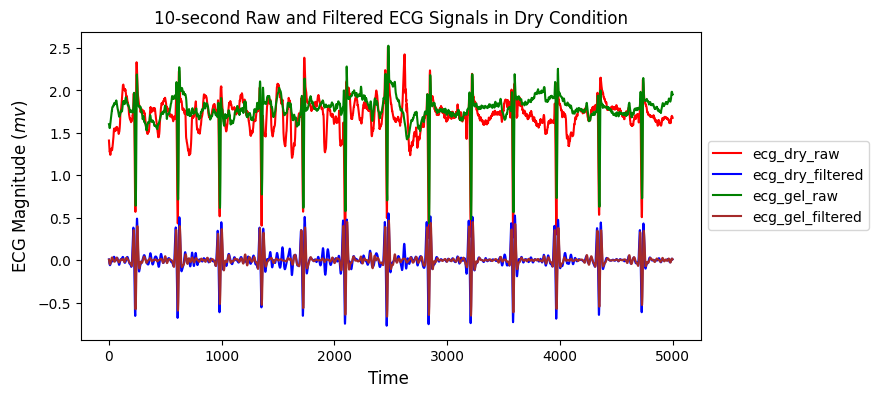

In [38]:
plt.figure(figsize = (8,4))
plt.plot(ecg_dry, color='red', label="ecg_dry_raw")
plt.plot(filtered_ecg_dry, color='blue', label = "ecg_dry_filtered")
plt.plot(ecg_gel, color='green', label="ecg_gel_raw")
plt.plot(filtered_ecg_gel, color='brown', label = "ecg_gel_filtered")
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
#plt.legend(loc='upper right')
plt.ylabel("ECG Magnitude ($mv$)", fontsize=12)
plt.xlabel("Time ", fontsize = 12)
plt.title("10-second Raw and Filtered ECG Signals in Dry Condition")
plt.savefig("10s_ECG.png")
plt.show()

##### The filtered signals from "dry" and "gel" conditions are very similar. Moreover, both signals are taken from left wrist.  To simplify the anaylsis and avoid redundancy, we will only use the "ecg:dry" signal for further analysis. 

In [45]:
r_peaks_locs=biobss.ecgtools.ecg_detectpeaks(sig = filtered_ecg_dry,sampling_rate = fs,method='elgendi')
r_peaks = ecg_dry[r_peaks_locs]

_, fiducials = nk.ecg_delineate(ecg_cleaned=filtered_ecg_dry, rpeaks=r_peaks_locs, sampling_rate=fs, method='peak')

p_peaks_locs = fiducials['ECG_P_Peaks']
q_peaks_locs = fiducials['ECG_Q_Peaks']
s_peaks_locs = fiducials['ECG_S_Peaks']
t_peaks_locs = fiducials['ECG_T_Peaks']
p_onset_locs = fiducials['ECG_P_Onsets']
t_offset_locs = fiducials['ECG_T_Offsets']

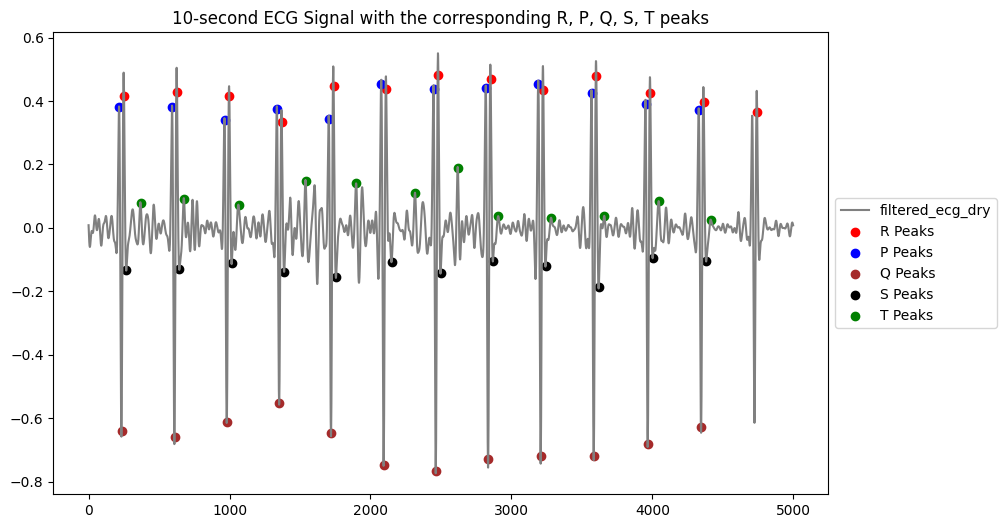

In [46]:
plt.figure(figsize = (10, 6))
plt.plot(filtered_ecg_dry, color = 'grey', label='filtered_ecg_dry')
plt.scatter(r_peaks_locs, filtered_ecg_dry[r_peaks_locs], color='red', label="R Peaks")
plt.scatter(p_peaks_locs[:-1], filtered_ecg_dry[p_peaks_locs[:-1]], color='blue', label="P Peaks")
plt.scatter(q_peaks_locs[:-1], filtered_ecg_dry[q_peaks_locs[:-1]], color='brown', label="Q Peaks")
plt.scatter(s_peaks_locs[:-1], filtered_ecg_dry[s_peaks_locs[:-1]], color='black', label="S Peaks")
plt.scatter(t_peaks_locs[:-1], filtered_ecg_dry[t_peaks_locs[:-1]], color='green', label="T Peaks")
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.title("10-second ECG Signal with the corresponding R, P, Q, S, T peaks")
plt.show()

#### Features from R peaks

In principle, one can extract a lot of features from a 10-second window using all the peaks (R, P, Q, S, T), in the following, we will focus on the features from the R-peaks.

The from_Rpeaks function calculates morphological features using R-peak locations. These features are:

* 'a_R': Amplitude of R peak
* 'RR0': Previous RR interval
* 'RR1': Current RR interval
* 'RR2': Subsequent RR interval
* 'RRm': Mean of RR0, RR1 and RR2
* 'RR_0_1': Ratio of RR0 to RR1
* 'RR_2_1': Ratio of RR2 to RR1
* 'RR_m_1': Ratio of RRm to RR1

In [48]:
ecg_dry_features = biobss.ecgtools.ecg_features.from_Rpeaks(filtered_ecg_dry,r_peaks_locs, fs,
                                                            prefix='ecgDry', average=True)
ecg_dry_features

{'ecgDry_a_R': 0.43529206262986236,
 'ecgDry_RR0': 0.7468,
 'ecgDry_RR1': 0.7474000000000001,
 'ecgDry_RR2': 0.749,
 'ecgDry_RRm': 0.7477333333333334,
 'ecgDry_RR_0_1': 0.9992603134701424,
 'ecgDry_RR_2_1': 1.0021796497398787,
 'ecgDry_RR_m_1': 1.000479987736674}

# 2. PPG

A Photoplethysmography (PPG) signal is a non-invasive measurement technique that analyzes back-scattered optical radiation from the skin to study blood volume pulsations.

There are two recordings of PPG signals "ppg:Left index finger" and "ppg:Left Wrist" taken from the left index finger adn the left wrist, respectively.

In [54]:
# We extract 10-second time series from the "walk_before" activity.

ppg_finger = signals_copy.iloc[events['onset'][4] + n_timepoints*(1-1): events['onset'][4]+n_timepoints*1,:]['ppg:Left index finger'].values
ppg_wrist =signals_copy.iloc[events['onset'][4] + n_timepoints*(1-1): events['onset'][4]+n_timepoints*1,:]['ppg:Left Wrist'].values

filtered_ppg_finger = biobss.preprocess.filter_signal(ppg_finger, sampling_rate=fs, 
                                                      signal_type='PPG', method='bandpass')
filtered_ppg_wrist = biobss.preprocess.filter_signal(ppg_wrist, sampling_rate=fs, 
                                                      signal_type='PPG', method='bandpass')

/Users/mingli/Documents/anaconda3/lib/python3.11/site-packages/biobss-0.1.1-py3.11.egg/biobss/ppgtools/ppg_filter.py:43: UserWarning: Default parameters will be used for filtering. 2th order bandpass filter with f1=0.5 Hz and f2=5 Hz.
  warnings.warn(


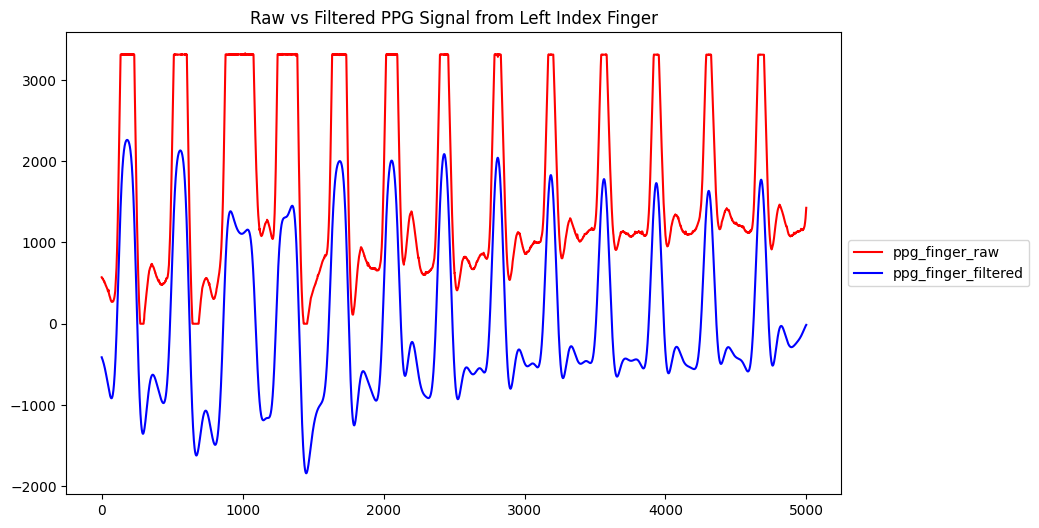

In [56]:
plt.figure(figsize = (10,6))
plt.plot(ppg_finger, color='red', label="ppg_finger_raw")
plt.plot(filtered_ppg_finger, color='blue', label = "ppg_finger_filtered")
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.title("Raw vs Filtered PPG Signal from Left Index Finger")
plt.show()

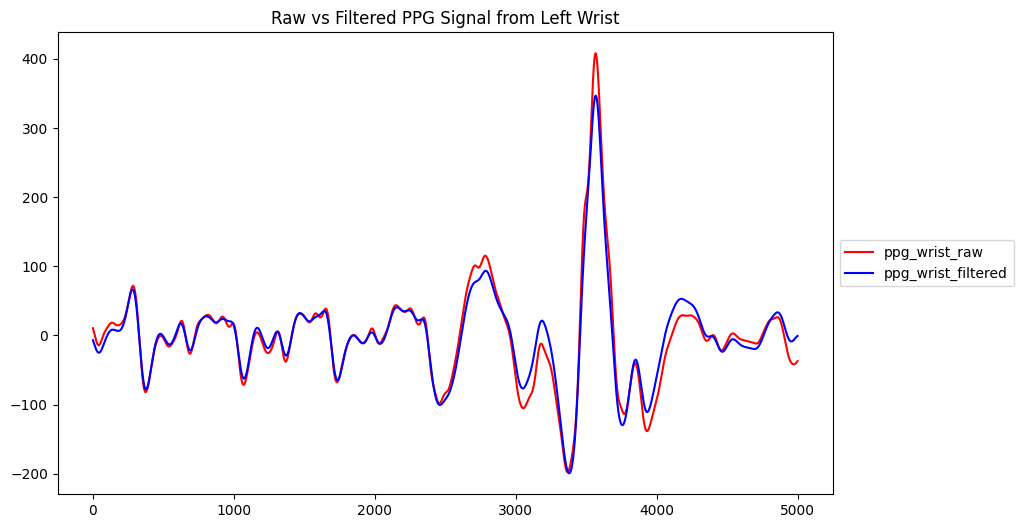

In [59]:
plt.figure(figsize = (10,6))
plt.plot(ppg_wrist, color='red', label="ppg_wrist_raw")
plt.plot(filtered_ppg_wrist, color='blue', label = "ppg_wrist_filtered")
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.title("Raw vs Filtered PPG Signal from Left Wrist")
plt.show()

For the "ppg:Left index finger", the filtering function somehow modifies the PPG signals. In the following, we will just use the raw data for further analysis. It is also unclear why the ppg signals from the left wrist are so different from the ppg signals from the left index finger.

In [60]:
#detecting the peaks and troughs of the PPG signals

info_finger=biobss.ppgtools.ppg_detectpeaks(sig=filtered_ppg_finger, sampling_rate=fs,method='peakdet', delta=0.05, correct_peaks=True)

locs_peaks_finger=info_finger['Peak_locs']
peaks_finger=filtered_ppg_finger[locs_peaks_finger]
locs_onsets_finger=info_finger['Trough_locs']
onsets_finger=filtered_ppg_finger[locs_onsets_finger]



info_wrist=biobss.ppgtools.ppg_detectpeaks(sig=filtered_ppg_wrist, sampling_rate=fs, method='peakdet', delta=0.05, correct_peaks=True)

locs_peaks_wrist=info_wrist['Peak_locs']
peaks_wrist=filtered_ppg_wrist[locs_peaks_wrist]
locs_onsets_wrist=info_wrist['Trough_locs']
onsets_wrist=filtered_ppg_wrist[locs_onsets_wrist]

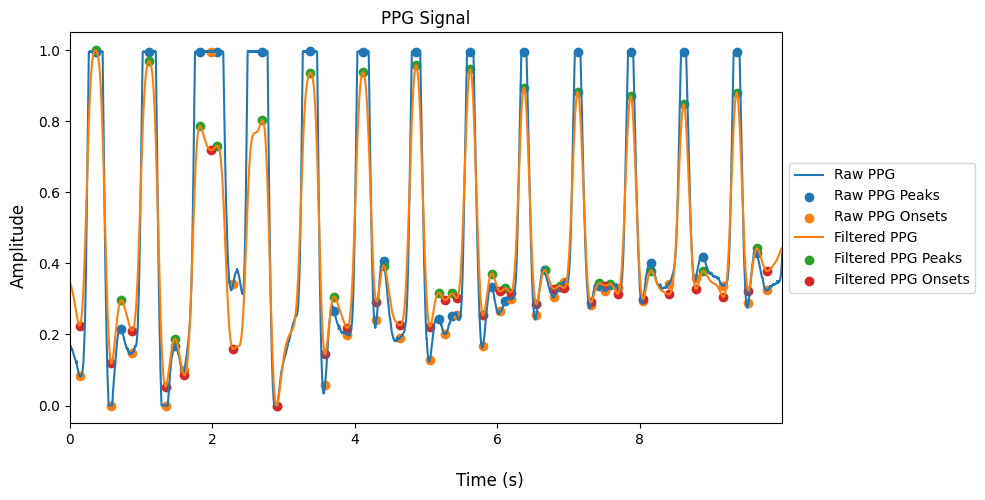

In [62]:
signals_finger={'Raw': ppg_finger, 'Filtered': filtered_ppg_finger}
peaks_finger={'Raw':{'Peaks': locs_peaks_finger, 'Onsets': locs_onsets_finger} , 'Filtered': {'Peaks': locs_peaks_finger, 'Onsets':locs_onsets_finger}}

biobss.ppgtools.plot_ppg(signals=signals_finger, peaks=peaks_finger, sampling_rate=fs, show_peaks=True, rescale=True, figsize=(10,5))


#### Extracting features from PPG signals

##### Time domain / morphological features:

Cycle-based features:

* a_S: Mean amplitude of the systolic peaks
* t_S: Mean systolic peak duration
* t_C: Mean cycle duration
* DW: Mean diastolic peak duration
* SW_10: The systolic peak duration at 10% amplitude of systolic amplitude
* SW_25: The systolic peak duration at 25% amplitude of systolic amplitude
* SW_33: The systolic peak duration at 33% amplitude of systolic amplitude
* SW_50: The systolic peak duration at 50% amplitude of systolic amplitude
* SW_66: The systolic peak duration at 66% amplitude of systolic amplitude
* SW_75: The systolic peak duration at 75% amplitude of systolic amplitude
* DW_10: The diastolic peak duration at 10% amplitude of systolic amplitude
* DW_25: The diastolic peak duration at 25% amplitude of systolic amplitude
* DW_33: The diastolic peak duration at 33% amplitude of systolic amplitude
* DW_50: The diastolic peak duration at 50% amplitude of systolic amplitude
* DW_66: The diastolic peak duration at 66% amplitude of systolic amplitude
* DW_75: The diastolic peak duration at 75% amplitude of systolic amplitude
* DW_SW_10: The ratio of diastolic peak duration to systolic peak duration at 10% amplitude of systolic amplitude
* DW_SW_25: The ratio of diastolic peak duration to systolic peak duration at 25% amplitude of systolic amplitude
* DW_SW_33: The ratio of diastolic peak duration to systolic peak duration at 33% amplitude of systolic amplitude
* DW_SW_50: The ratio of diastolic peak duration to systolic peak duration at 50% amplitude of systolic amplitude
* DW_SW_66: The ratio of diastolic peak duration to systolic peak duration at 66% amplitude of systolic amplitude
* DW_SW_75: The ratio of diastolic peak duration to systolic peak duration at 75% amplitude of systolic amplitude
* PR_mean: Mean pulse rate
* a_D: Mean amplitude of the diastolic peaks
* t_D: Mean difference between diastolic peak and onset
* r_D: Mean ratio of the diastolic peak amplitude to diastolic peak duration
* a_N: Mean amplitude of the dicrotic notchs
* t_N: Mean dicrotic notch duration
* r_N: Mean ratio of the dicrotic notch amplitude to dicrotic notch duration
* dT: Mean duration from systolic to diastolic peaks
* r_D_NC: Mean ratio of diastolic peak amplitudes to difference between ppg wave duration and dictoric notch duration
* r_N_NC: Mean ratio of dicrotic notch amplitudes to difference between ppg wave duration and dictoric notch duration
* a_N_S: Mean ratio of dicrotic notch amplitudes to systolic peak amplitudes
* AI: Mean ratio of diastolic peak amplitudes to systolic peak amplitudes
* AI_2: Mean ratio of difference between systolic and diastolic peak amplitudes to systolic peak amplitudes


Segment-based features:

* zcr: Zero crossing rate
* snr: Signal to noise ratio


##### Frequency domain features:

Segment-based features:

* p_1: The amplitude of the first peak from the fft of the signal
* f_1: The frequency at which the first peak from the fft of the signal occurred
* p_2: The amplitude of the second peak from the fft of the signal
* f_2: The frequency at which the second peak from the fft of the signal occurred
* p_3: The amplitude of the third peak from the fft of the signal
* f_3: The frequency at which the third peak from the fft of the signal occurred
* pow: Power of the signal at a given range of frequencies
* rpow: Ratio of the powers of the signal at given ranges of frequencies

##### Statistical features:

Cycle-based features:

* mean_peaks: Mean of the peak amplitudes
* std_peaks: Standard deviation of the peak amplitudes

Segment-based features:

* mean: Mean value of the signal
* median: Median value of the signal
* std: Standard deviation of the signal
* pct_25: 25th percentile of the signal
* pct_75 75th percentile of the signal
* mad: Mean absolute deviation of the signal
* skewness: Skewness of the signal
* kurtosis: Kurtosis of the signal
* entropy: Entropy of the signal


In [64]:
# features from the "ppg:Left index finger".
features_all_finger = biobss.ppgtools.get_ppg_features(filtered_ppg_finger, sampling_rate=fs, 
                                                input_types=['cycle','segment'], 
                                                feature_domain={'cycle':['Time','stat'],'segment':['time','freq','stat']}, 
                                                peaks_locs=locs_peaks_finger, peaks_amp=peaks_finger, 
                                                troughs_locs=locs_onsets_finger, troughs_amp=onsets_finger,
                                                prefix = 'ppgF')
features_all_finger

{'ppgF_a_S': 644.2606935016823,
 'ppgF_t_S': 0.1680689655172414,
 'ppgF_t_C': 0.3327586206896551,
 'ppgF_DW': 0.16468965517241382,
 'ppgF_SW_10': 0.12799999999999997,
 'ppgF_SW_25': 0.10413793103448275,
 'ppgF_SW_33': 0.09558620689655171,
 'ppgF_SW_50': 0.07972413793103447,
 'ppgF_SW_66': 0.06531034482758621,
 'ppgF_SW_75': 0.056137931034482766,
 'ppgF_DW_10': 0.12931034482758622,
 'ppgF_DW_25': 0.11475862068965519,
 'ppgF_DW_33': 0.10648275862068966,
 'ppgF_DW_50': 0.09048275862068966,
 'ppgF_DW_66': 0.07220689655172413,
 'ppgF_DW_75': 0.06241379310344829,
 'ppgF_DW_SW_10': 1.0963486303810617,
 'ppgF_DW_SW_25': 1.1701548425332704,
 'ppgF_DW_SW_33': 1.1745291913667113,
 'ppgF_DW_SW_50': 1.1955769923126582,
 'ppgF_DW_SW_66': 1.1697817759123077,
 'ppgF_DW_SW_75': 1.1872643086978625,
 'ppgF_PR_mean': 181.0344827586207,
 'ppgF_mean_peaks': 644.2606935016823,
 'ppgF_std_peaks': 1153.5015390366493,
 'ppgF_zcr': 0.0052,
 'ppgF_snr': 0.007139204378993091,
 'ppgF_p_1': 911.1885875843694,
 'ppgF

In [65]:
# features from the left wrist
features_all_wrist = biobss.ppgtools.get_ppg_features(sig=filtered_ppg_wrist, sampling_rate=fs,
                                                      input_types=['cycle','segment'], 
                                                      feature_domain={'cycle':['Time','Stat'],'segment':['time','freq','stat']},
                                                      peaks_locs=locs_peaks_wrist, peaks_amp=peaks_wrist,
                                                      troughs_locs=locs_onsets_wrist, troughs_amp=onsets_wrist,
                                                      prefix = 'ppgW')

features_all_wrist

{'ppgW_a_S': 36.702400924406426,
 'ppgW_t_S': 0.21782608695652173,
 'ppgW_t_C': 0.427304347826087,
 'ppgW_DW': 0.2094782608695652,
 'ppgW_SW_10': 0.17426086956521739,
 'ppgW_SW_25': 0.14756521739130432,
 'ppgW_SW_33': 0.136,
 'ppgW_SW_50': 0.11243478260869565,
 'ppgW_SW_66': 0.08991304347826087,
 'ppgW_SW_75': 0.07600000000000001,
 'ppgW_DW_10': 0.15686956521739132,
 'ppgW_DW_25': 0.1411304347826087,
 'ppgW_DW_33': 0.13208695652173913,
 'ppgW_DW_50': 0.11582608695652173,
 'ppgW_DW_66': 0.09965217391304347,
 'ppgW_DW_75': 0.0847826086956522,
 'ppgW_DW_SW_10': 0.8890556719188495,
 'ppgW_DW_SW_25': 0.9581341898822321,
 'ppgW_DW_SW_33': 0.9594396537695082,
 'ppgW_DW_SW_50': 0.9914737832127081,
 'ppgW_DW_SW_66': 1.064930332940687,
 'ppgW_DW_SW_75': 1.1002405220030314,
 'ppgW_PR_mean': 139.9194403222387,
 'ppgW_mean_peaks': 36.702400924406426,
 'ppgW_std_peaks': 70.99220276215816,
 'ppgW_zcr': 0.006,
 'ppgW_snr': -0.0015530748848319414,
 'ppgW_p_1': 45.24129175087386,
 'ppgW_f_1': 0.70000000

# 3. ACC

An accelerometer (ACC) signal can be used to measure movements in biomechanics and biomedical devices

The ACC signals (accelerometer) measures the accelerations along X, Y, Z three directions. Intuitively, this is the most important signals to predict different human activities. The "acc:chest" signal comes from sensors on the chest while the "acc:e4" signal comes from sensors on the wrist.

In [23]:
accx_chest = signals_copy.iloc[events['onset'][4] + n_timepoints*(1-1): events['onset'][4]+n_timepoints*1,:]['acc_chest:x'].values

accy_chest = signals_copy.iloc[events['onset'][4] + n_timepoints*(1-1): events['onset'][4]+n_timepoints*1,:]['acc_chest:y'].values

accz_chest = signals_copy.iloc[events['onset'][4] + n_timepoints*(1-1): events['onset'][4]+n_timepoints*1,:]['acc_chest:z'].values


filtered_accx_chest=biobss.preprocess.filter_signal(sig=accx_chest, sampling_rate=fs, signal_type='ACC', method='lowpass')
filtered_accy_chest=biobss.preprocess.filter_signal(sig=accy_chest, sampling_rate=fs, signal_type='ACC', method='lowpass')
filtered_accz_chest=biobss.preprocess.filter_signal(sig=accz_chest, sampling_rate=fs, signal_type='ACC', method='lowpass')


accx_wrist = signals_copy.iloc[events['onset'][4] + n_timepoints*(1-1): events['onset'][4]+n_timepoints*1,:]['acc_e4:x'].values

accy_wrist = signals_copy.iloc[events['onset'][4] + n_timepoints*(1-1): events['onset'][4]+n_timepoints*1,:]['acc_e4:y'].values

accz_wrist = signals_copy.iloc[events['onset'][4] + n_timepoints*(1-1): events['onset'][4]+n_timepoints*1,:]['acc_e4:z'].values


filtered_accx_wrist=biobss.preprocess.filter_signal(sig=accx_wrist, sampling_rate=fs, signal_type='ACC', method='lowpass')
filtered_accy_wrist=biobss.preprocess.filter_signal(sig=accy_wrist, sampling_rate=fs, signal_type='ACC', method='lowpass')
filtered_accz_wrist=biobss.preprocess.filter_signal(sig=accz_wrist, sampling_rate=fs, signal_type='ACC', method='lowpass')


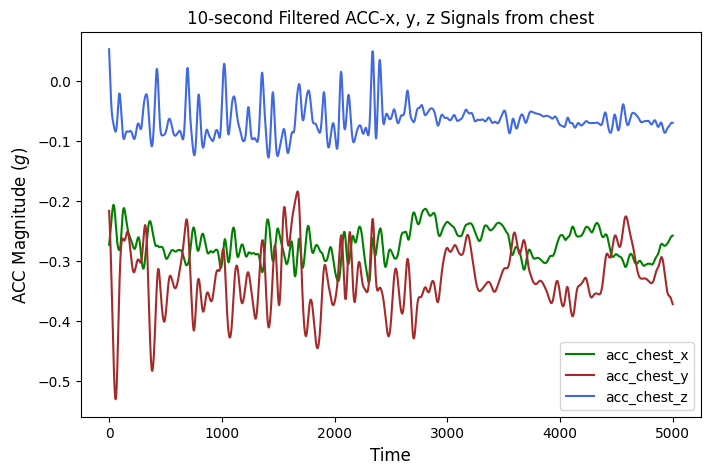

In [29]:
plt.figure(figsize = (8,5))
plt.plot(filtered_accx_chest, color='green', label="acc_chest_x")
plt.plot(filtered_accy_chest, color='brown', label = "acc_chest_y")
plt.plot(filtered_accz_chest, color='royalblue', label = "acc_chest_z")
plt.legend(loc = "lower right")
#plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.title("10-second Filtered ACC-x, y, z Signals from chest")
plt.xlabel("Time", fontsize = 12)
plt.ylabel("ACC Magnitude ($g$)",fontsize = 12)
plt.savefig("10s_ACC.png")
plt.show()

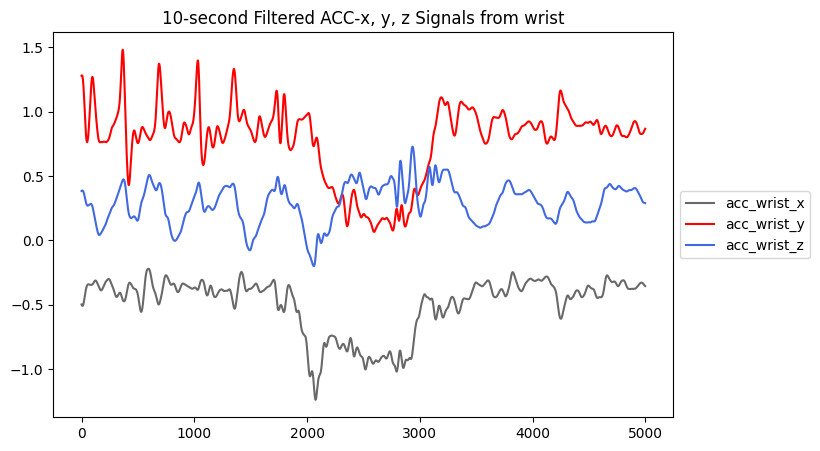

In [92]:
plt.figure(figsize = (8,5))
plt.plot(filtered_accx_wrist, color='dimgray', label="acc_wrist_x")
plt.plot(filtered_accy_wrist, color='red', label = "acc_wrist_y")
plt.plot(filtered_accz_wrist, color='royalblue', label = "acc_wrist_z")

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.title("10-second Filtered ACC-x, y, z Signals from wrist")
plt.show()

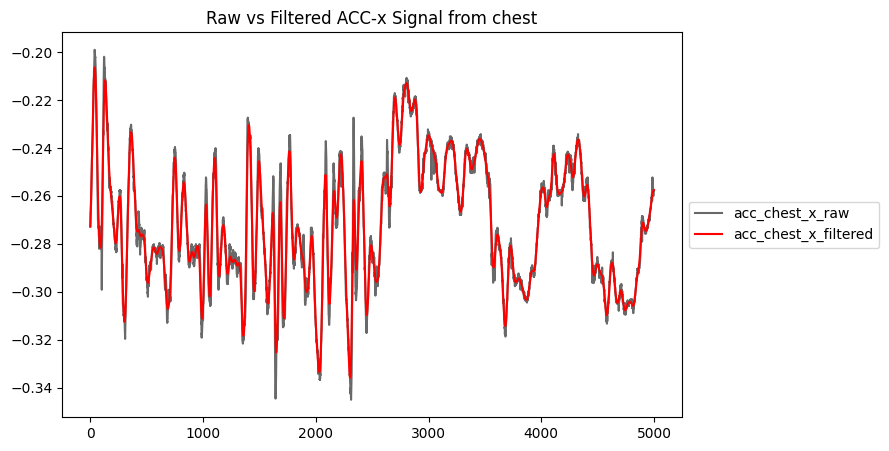

In [87]:
plt.figure(figsize = (8,5))
plt.plot(accx, color='dimgray', label="acc_chest_x_raw")
plt.plot(filtered_accx, color='red', label = "acc_chest_x_filtered")
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.title("Raw vs Filtered ACC-x Signal from chest")
plt.show()

In [67]:
accx_info=biobss.preprocess.peak_detection(sig=filtered_accx, sampling_rate=fs, method='peakdet', delta=0.01)

accx_locs_peaks=accx_info['Peak_locs']
accx_peaks=filtered_accx[accx_locs_peaks]
accx_locs_onsets=accx_info['Trough_locs']
accx_onsets=filtered_accx[accx_locs_onsets]

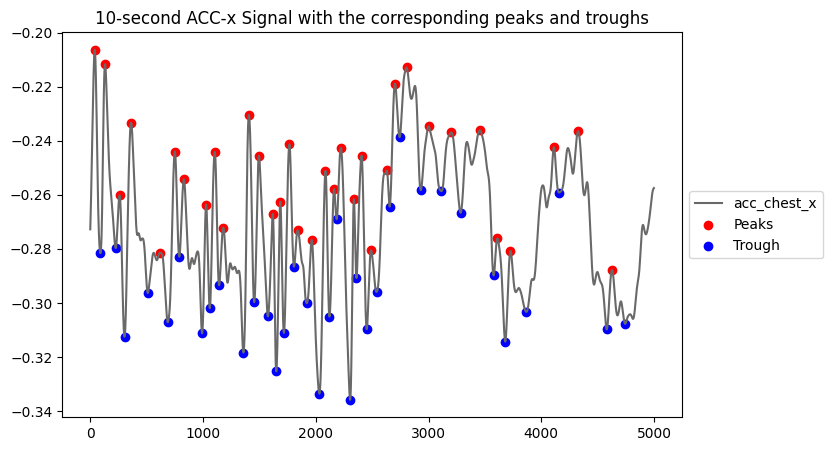

In [88]:
plt.figure(figsize = (8,5))
plt.plot(filtered_accx, color = 'dimgray', label='acc_chest_x')
plt.scatter(accx_locs_peaks, accx_peaks, color='red', label="Peaks")
plt.scatter(accx_locs_onsets, accx_onsets, color='blue', label="Trough")
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.title("10-second ACC-x Signal with the corresponding peaks and troughs")
plt.show()

The filtered ACC signal is much more smooth compared to the raw data.

#### ACC Feature Extraction

Statistical features:

* mean: mean of the signal amplitude
* std: standard deviation of the signal amplitude
* mad: mean absolute deviation of the signal amplitude
* min: minimum value of the signal amplitude
* max: maximum value of the signal amplitude
* range: difference of maximum and minimum values of the signal amplitude
* median: median value of the signal amplitude
* medad: median absolute deviation of the signal amplitude
* iqr: interquartile range of the signal amplitude
* ncount: number of negative values
* pcount: number of positibe values
* abmean: number of values above mean
* npeaks: number of peaks
* skew: skewness of the signal
* kurtosis: kurtosis of the signal
* energy: signal energy (the mean of sum of squares of the values in a window)
* momentum: signal momentum

Frequency domain features:

* fft_mean: mean of fft peaks
* fft_std: standard deviation of fft peaks
* fft_mad: mean absolute deviation of fft peaks
* fft_min: minimum value of fft peaks
* fft_max: maximum value of fft peaks
* fft_range: difference of maximum and minimum values of fft peaks
* fft_median: median value of fft peaks
* fft_medad: median absolute deviation of fft peaks
* fft_iqr: interquartile range of fft peaks
* fft_abmean: number of fft peaks above mean
* fft_npeaks: number of fft peaks
* fft_skew: skewness of fft peaks
* fft_kurtosis: kurtosis of fft peaks
* fft_energy: energy of fft peaks
* fft_entropy: entropy of fft peaks
* f1sc: signal power in the range of 0.1 to 0.2 Hz
* f2sc: signal power in the range of 0.2 to 0.3 Hz
* f3sc: signal power in the range of 0.3 to 0.4 Hz
* max_freq: frequency of maximum fft peak

Correlation features:

* accx_accy_corr: correlation coefficient for x and y axes
* accx_accz_corr: correlation coefficient for x and z axes
* accy_accz_corr: correlation coefficient for y and z axes

Reference: https://towardsdatascience.com/feature-engineering-on-time-series-data-transforming-signal-data-of-a-smartphone-accelerometer-for-72cbe34b8a60


In [93]:
acc_chest_sig = [filtered_accx_chest, filtered_accy_chest, filtered_accz_chest]
acc_chest_name = ['accxCH', 'accyCH', 'acczCH']

acc_chest_features = biobss.imutools.get_acc_features(signals=acc_chest_sig, signal_names=acc_chest_name, sampling_rate=fs)
acc_chest_features

{'accxCH_fft_mean': 0.0002219663841341431,
 'accxCH_fft_std': 0.005478053267672737,
 'accxCH_fft_mad': 0.00040683677685380084,
 'accxCH_fft_min': 1.6019508201832515e-06,
 'accxCH_fft_max': 0.27178530498475806,
 'accxCH_fft_range': 0.2717837030339379,
 'accxCH_fft_median': 4.541970758469805e-06,
 'accxCH_fft_medad': 1.2733800577541938e-06,
 'accxCH_fft_iqr': 4.998513998174671e-06,
 'accxCH_fft_abmean': 112,
 'accxCH_fft_npeaks': 255,
 'accxCH_fft_skew': 48.75120412727293,
 'accxCH_fft_kurtosis': 2412.7171825720643,
 'accxCH_fft_energy': 0.0007514584169786386,
 'accxCH_fft_entropy': -2.0626059954700318,
 'accxCH_f1sc': 0.0,
 'accxCH_f2sc': 0.0,
 'accxCH_f3sc': 0.0,
 'accxCH_max_freq': 0.2,
 'accyCH_fft_mean': 0.0004068788594415032,
 'accyCH_fft_std': 0.006726910802105795,
 'accyCH_fft_mad': 0.0006433971744298851,
 'accyCH_fft_min': 1.5702598616875843e-05,
 'accyCH_fft_max': 0.3292238860816964,
 'accyCH_fft_range': 0.3292081834830795,
 'accyCH_fft_median': 4.4446413802557664e-05,
 'accyCH

# 4. EMG

Electromyography (EMG) signals are biomedical signals that measure the electrical currents produced by muscles when they contract. These signals are a function of time and are described by their amplitude, frequency, and phase. EMG signals are used to monitor medical abnormalities, activation levels, and animal movements. They are also used in clinical diagnosis, rehabilitation devices, and human-machine interactions.

In [59]:
ti=signals_copy.index[0]

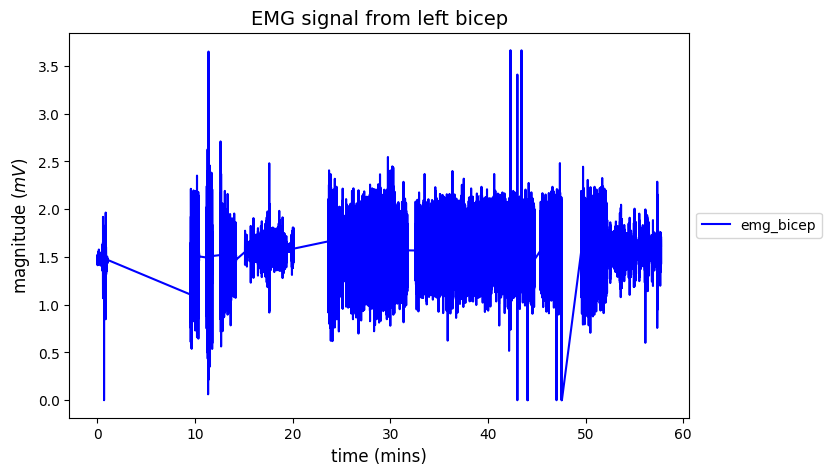

In [63]:
plt.figure(figsize = (8,5))
plt.plot(signals_copy['emg:Left Bicep'], color='blue', label="emg_bicep")
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.title("EMG signal from left bicep", fontsize=14)
plt.xlabel("time (mins)", fontsize=12)
plt.ylabel('magnitude ($mV$)', fontsize = 12)
plt.xticks([ti+timedelta(minutes=10*j) for j in range(7)],
               [str(j*10) for j in range(7)],
               fontsize=10)
plt.show()

In [53]:
emg_bicep = signals_copy.iloc[events['onset'][4] + n_timepoints*(1-1): events['onset'][4]+n_timepoints*1,:]['emg:Left Bicep'].values


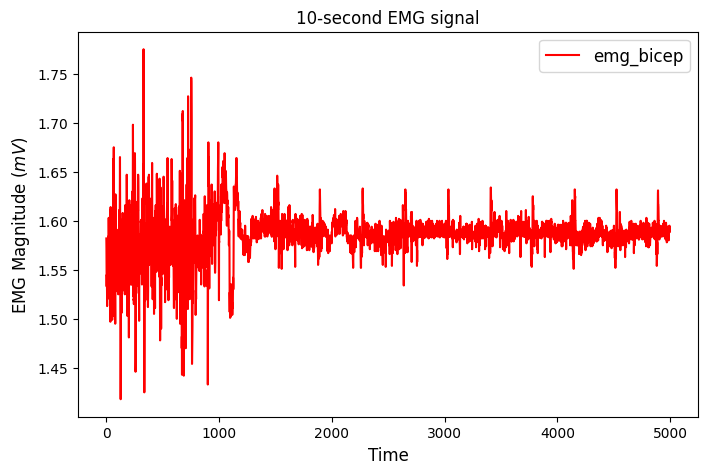

In [55]:
plt.figure(figsize = (8,5))
plt.plot(emg_bicep, color='red', label="emg_bicep")
plt.legend(loc='upper right', fontsize = 12)
plt.title("10-second EMG signal")
plt.xlabel("Time", fontsize = 12)
plt.ylabel("EMG Magnitude ($mV$)", fontsize=12)
plt.show()

# 5.  EDA 

Electrodermal Activity (EDA) – also referred to as Galvanic Skin Response (GSR) – refers to the variation of the electrical conductance of the skin in response to sweat secretion and is linked to mental states like stress, emotion, and cognitive states.

We explore the "eda:dry" and "eda:gel" biosignals.

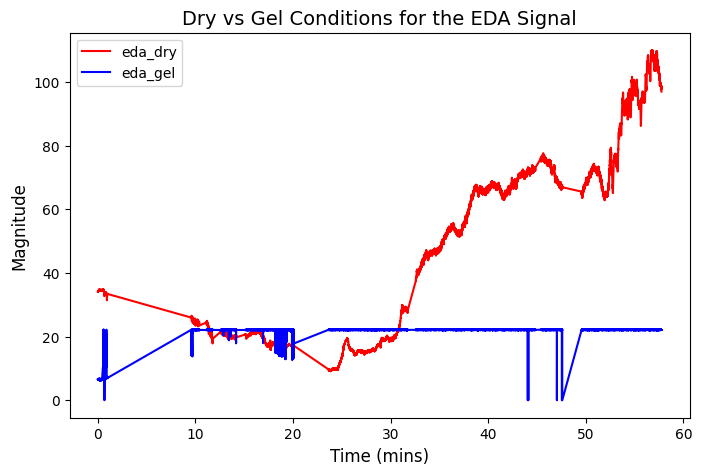

In [75]:
plt.figure(figsize = (8,5))
plt.plot(signals_copy['eda:dry'], color='red', label="eda_dry")
plt.plot(signals_copy['eda:gel'], color='blue', label = "eda_gel")
#plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.legend(loc='upper left')
plt.title("Dry vs Gel Conditions for the EDA Signal", fontsize=14)
plt.xlabel("Time (mins)", fontsize=12)
plt.ylabel('Magnitude', fontsize = 12)
plt.xticks([ti+timedelta(minutes=10*j) for j in range(7)],
               [str(j*10) for j in range(7)],
               fontsize=10)
plt.show()

##### The "eda:gel" signal looks very strange compared to the "eda:dry" signal. In further analysis, we will discard the "eda:gel" signal and only focused on the "eda:dry" signal. 

In [69]:
eda_dry = signals_copy.iloc[events['onset'][4] + n_timepoints*(1-1): events['onset'][4]+n_timepoints*1,:]['eda:dry'].values

filtered_eda_dry = biobss.edatools.eda_filter.filter_eda(eda_dry,fs)
    

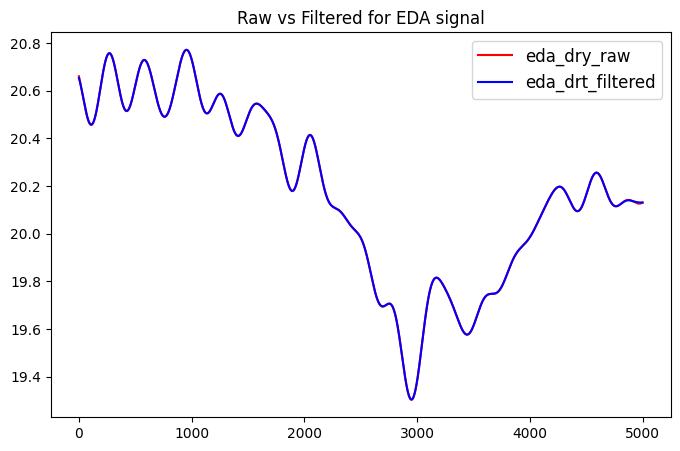

In [70]:
plt.figure(figsize = (8,5))
plt.plot(eda_dry, color='red', label="eda_dry_raw")
plt.plot(filtered_eda_dry, color='blue', label = "eda_drt_filtered")
plt.legend(loc='upper right', fontsize = 12)
plt.title("Raw vs Filtered for EDA signal")
plt.show()

In [71]:
# The EDA signal is usually decomposed into the Phasic and the Tonic components, 
# essentially the phase and the magnitude of the signal 

decomposed_eda_dry = biobss.edatools.eda_decompose(filtered_eda_dry,fs)
decomposed_eda_dry.head()

,EDA_Tonic,EDA_Phasic
0,20.523631,0.157497
1,20.523523,0.155884
2,20.523415,0.154240
3,20.523307,0.152565
4,20.523198,0.150861


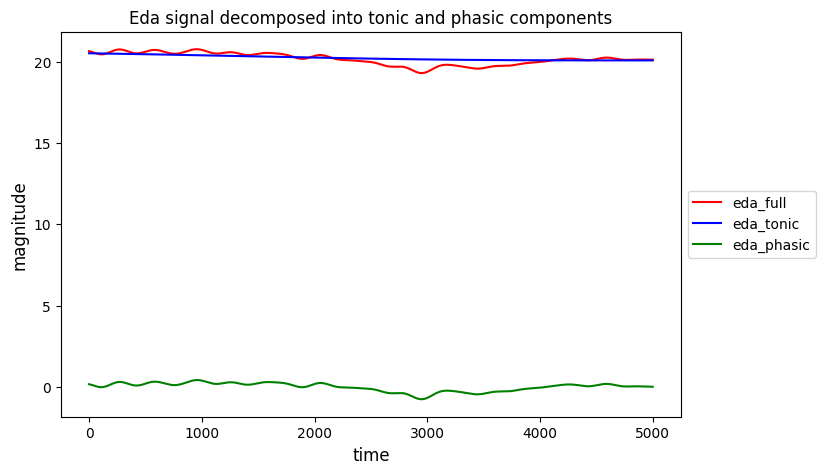

In [72]:
plt.figure(figsize = (8,5))
plt.plot(filtered_eda_dry, color='red', label="eda_full")
plt.plot(decomposed_eda_dry['EDA_Tonic'], color='blue', label = "eda_tonic")
plt.plot(decomposed_eda_dry['EDA_Phasic'], color='green', label = "eda_phasic")
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.title("Eda signal decomposed into tonic and phasic components")
plt.xlabel('time', fontsize=12)
plt.ylabel('magnitude', fontsize=12)
plt.show()

#### Extracting Features from EDA

The prefix "scr_" represents signals from the Phasic component while "scl_" represents signals from the Tonic component

In [111]:
eda_dry_features = biobss.edatools.eda_features.from_signal(filtered_eda_dry, sampling_rate=fs)
eda_dry_features

{'scr_mean': -0.01448903633817797,
 'scr_std': 0.2591717195887167,
 'scr_max': 0.41337487662674477,
 'scr_min': -0.7664980392992556,
 'scr_range': 1.1798729159260004,
 'scr_kurtosis': -0.01231878367239636,
 'scr_skew': -0.8157947736472424,
 'scr_momentum': 0.0671699802345723,
 'scr_activity': 0.06716998023457241,
 'scr_complexity': 3.1785514933524457,
 'scr_mobility': 0.005318877607859879,
 'scr_rms': 0.25957640957641226,
 'scr_acr_length': 4999.004752818259,
 'scr_integral': 1033.8044913901272,
 'scr_average_power': 0.06737991240858134,
 'scr_f1sc': 0.004687770490350507,
 'scr_f2sc': 0.003086726205178352,
 'scr_f3sc': 0.017862345369854427,
 'scr_Energy': 263.9552361369034,
 'scr_Entropy': 41.19806422804861,
 'scr_max_freq': 0.0,
 'scl_mean': 20.236664268223173,
 'scl_std': 0.14468060548859982,
 'scl_max': 20.523630849352546,
 'scl_min': 20.08349511187595,
 'scl_range': 0.44013573747659507,
 'scl_kurtosis': -1.1574462211746996,
 'scl_skew': 0.5347172632677281,
 'scl_momentum': 0.020932

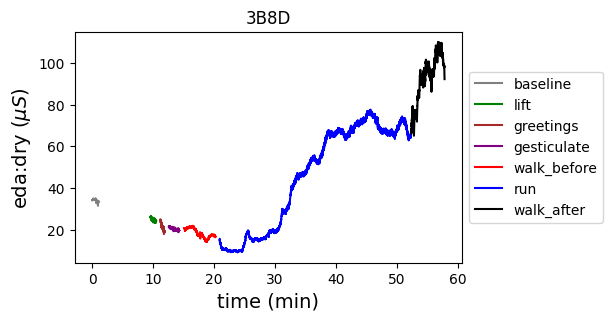

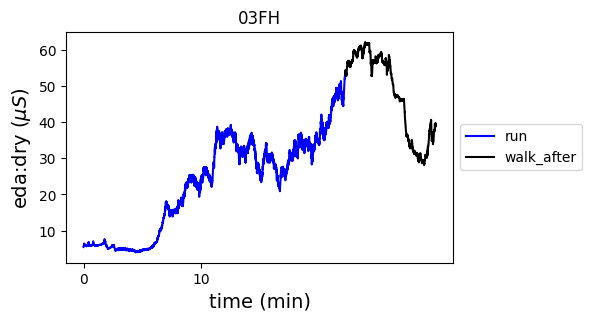

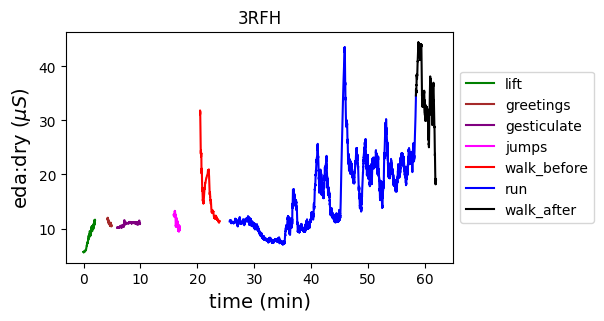

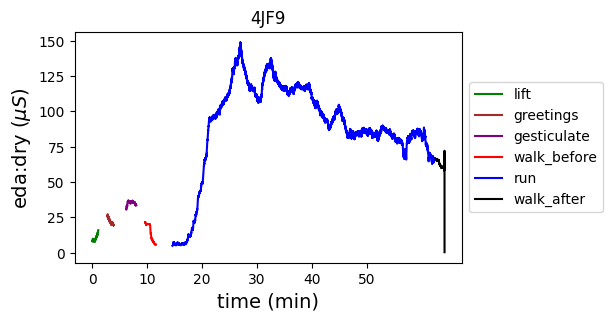

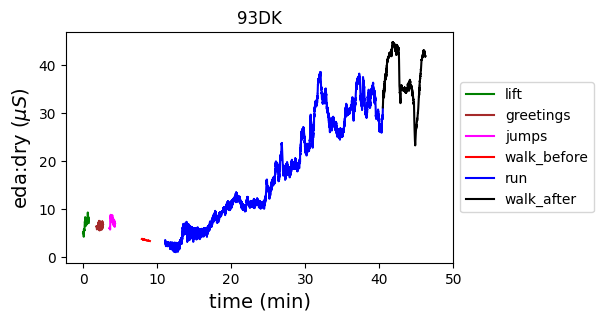

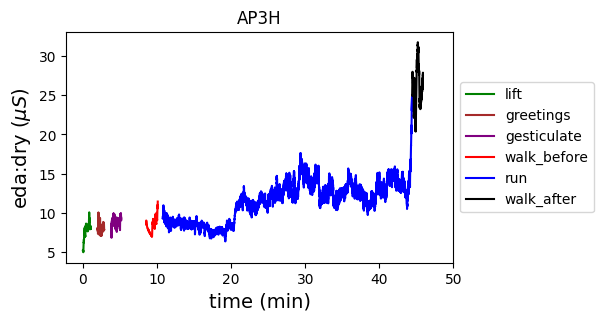

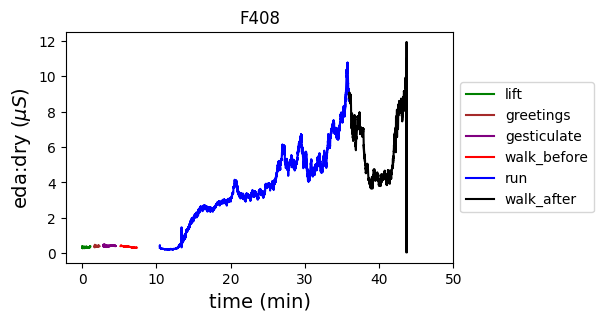

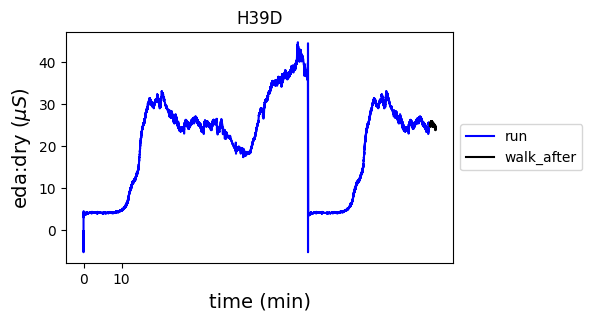

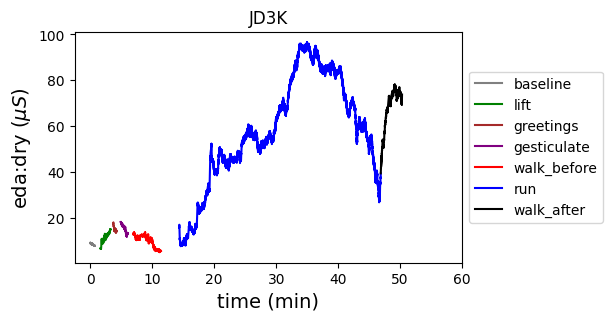

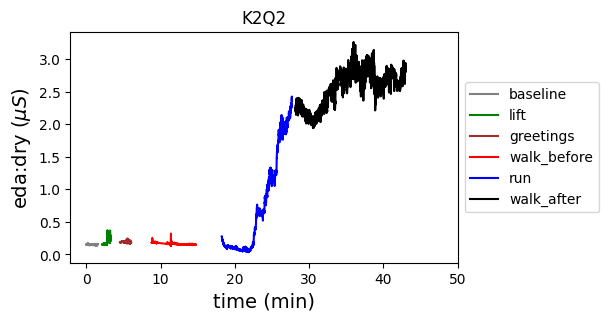

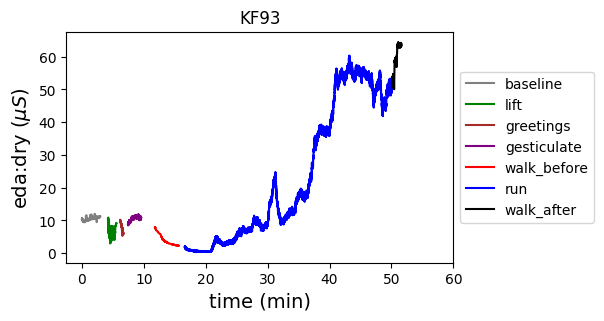

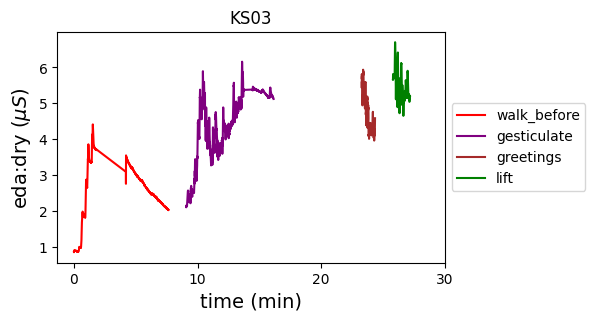

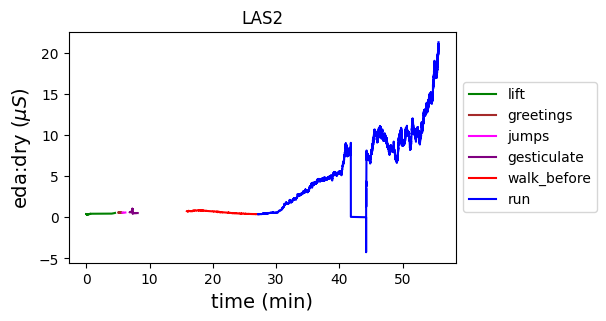

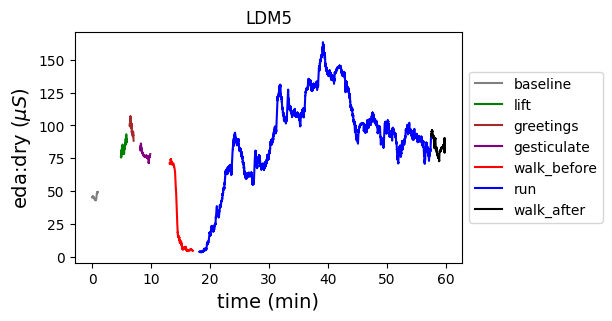

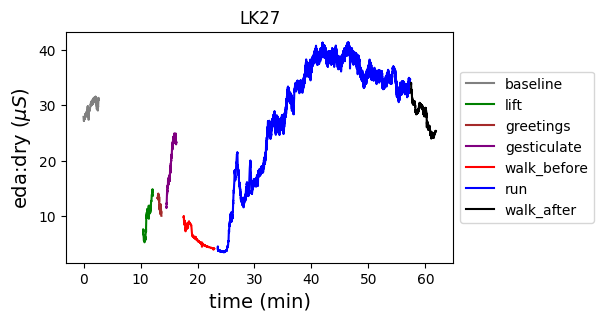

In [39]:
act_colors = ['grey','green', 'brown','purple', 'magenta','red', 'blue', 'black']
condition_list = ['baseline', 'lift', 'greetings', 'gesticulate', 'jumps', 'walk_before', 'run', 'walk_after']

for k in range(len(selected_participants)):
    code = selected_participants[k]
    signals = pd.read_csv(f'csv/{code}.csv', index_col=0, parse_dates=True, low_memory=False)
    
    signals_copy  = signals[['eda:dry', 'activities']].copy()
    act_column = signals_copy['activities'].unique()
    
    signals_copy.dropna(inplace=True)
    
    signals_copy['activities'] = signals_copy['activities'].replace(activity_encoder)
    signals_copy['activities']=pd.to_numeric(signals_copy['activities'])
    activity_num=signals_copy['activities'].unique()
    
    for i in range(1,9):
        if i in signals_copy['activities'].unique():
            change_row = signals_copy.loc[signals_copy['activities']==i].index[0]
            signals_copy.loc[change_row, 'activities']=0
    
    events = nk.events_find(event_channel=signals_copy['activities'], 
                        threshold = 0,
                        threshold_keep='above', 
                        event_conditions=activity_num)
    
    starting_min = signals_copy.index[events['onset'][0]]
    ending_min = signals_copy.index[events['onset'][-1]+events['duration'][-1]-1]
    
    plt.figure(figsize=(5,3))


    for j in range(len(activity_num)):
        plt.plot(signals_copy.index[events['onset'][j]:events['onset'][j]+events['duration'][j]]
             , signals_copy['eda:dry'][events['onset'][j]:events['onset'][j]+events['duration'][j]],
                 color = act_colors[activity_num[j]-1],label=condition_list[activity_num[j]-1])
    plt.title(code)
    plt.ylabel('eda:dry ($\mu S$)', fontsize=14)
    plt.xlabel('time (min)', fontsize = 14)
    plt.xticks([starting_min + timedelta(minutes=10*j) for j in range(len(activity_num))],
               [str(j*10) for j in range(len(activity_num))],
               fontsize=10)
    #plt.legend(loc='upper left', fontsize = 8)
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    #plt.savefig(f"EDA_{code}.png")
    plt.show()

### Summary on "eda:dry"

The "eda:dry" feature looks very promising. By eyeballing these figures, there is a roughly monotonic increasing behavior for the magnitude of the eda signal corresponding to different activities. 

## 6. Temperature 

We explore the temperature biosignal

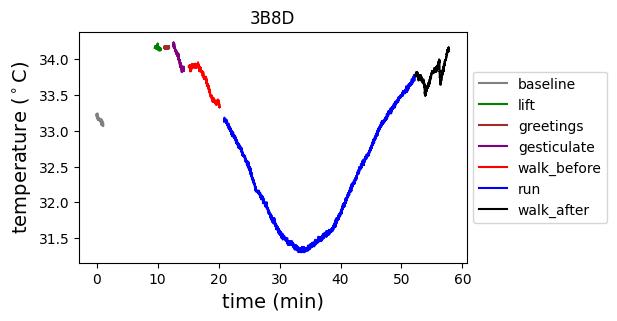

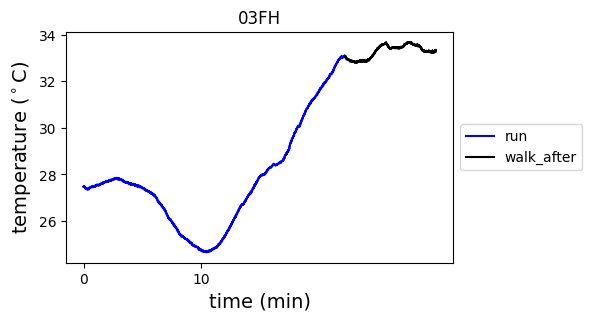

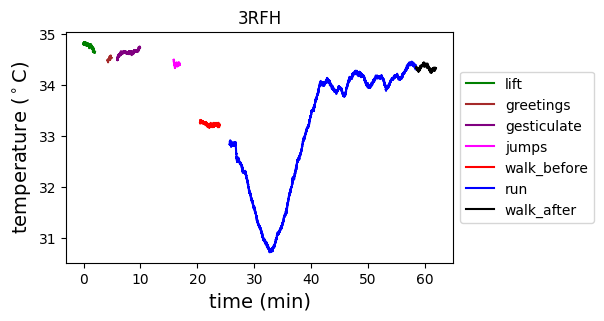

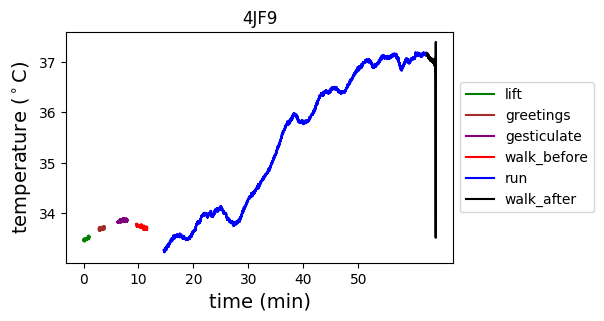

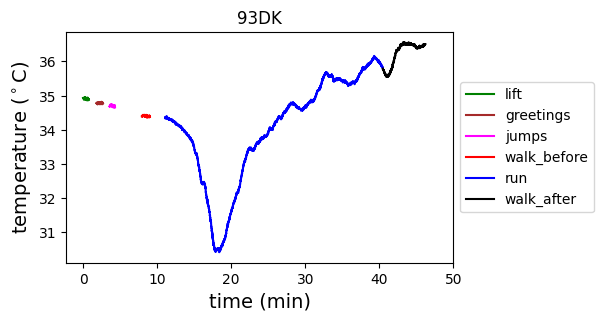

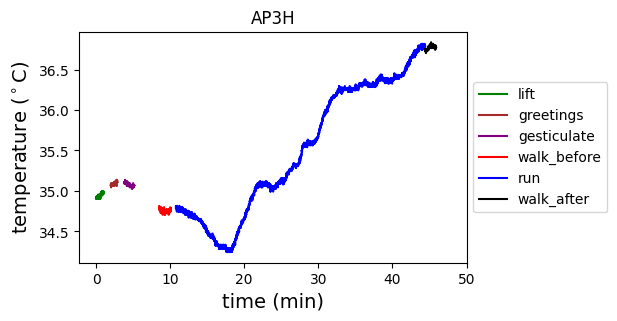

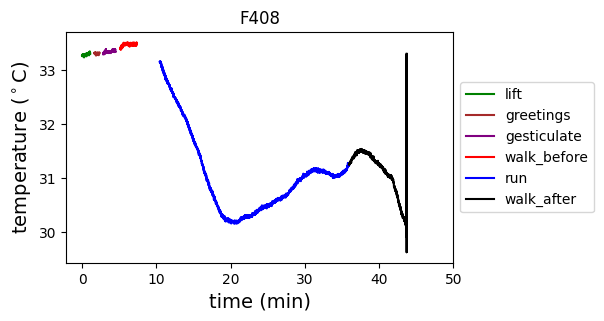

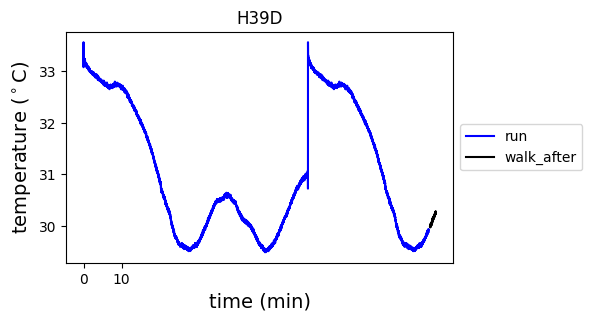

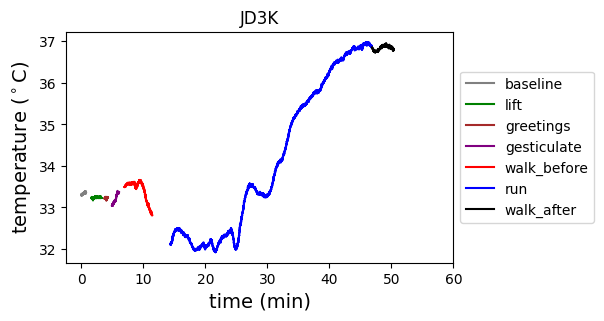

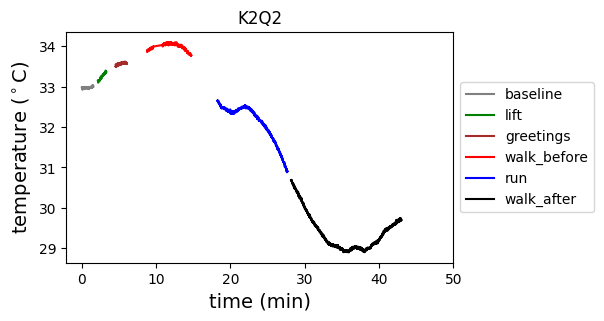

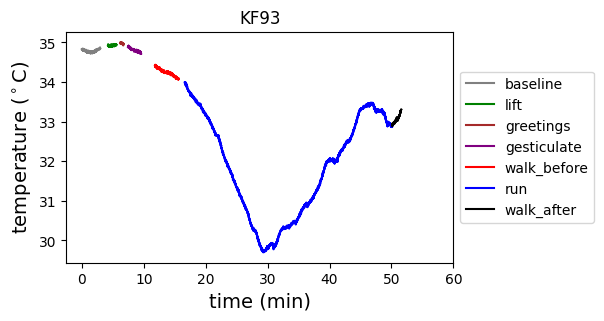

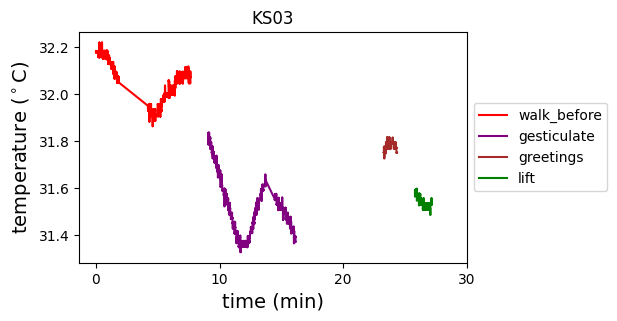

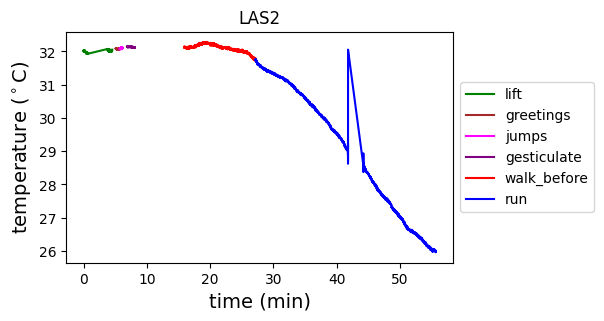

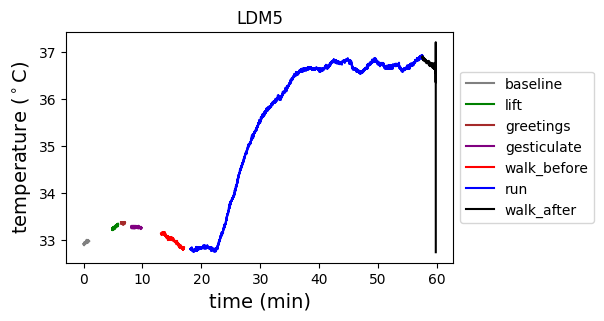

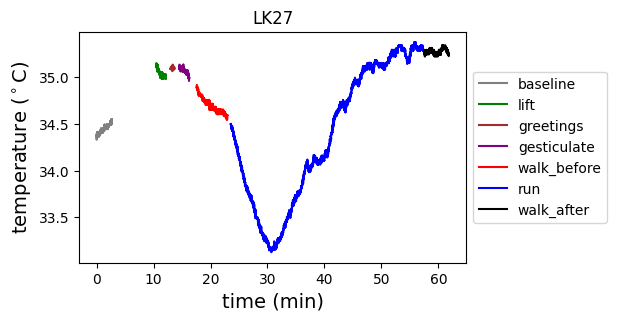

In [41]:
act_colors = ['grey','green', 'brown','purple', 'magenta','red', 'blue', 'black']
condition_list = ['baseline', 'lift', 'greetings', 'gesticulate', 'jumps', 'walk_before', 'run', 'walk_after']

for k in range(len(selected_participants)):
    code = selected_participants[k]
    signals = pd.read_csv(f'csv/{code}.csv', index_col=0, parse_dates=True, low_memory=False)
    
    signals_copy  = signals[['temp:temp', 'activities']].copy()
    act_column = signals_copy['activities'].unique()
    
    signals_copy.dropna(inplace=True)
    
    signals_copy['activities'] = signals_copy['activities'].replace(activity_encoder)
    signals_copy['activities']=pd.to_numeric(signals_copy['activities'])
    activity_num=signals_copy['activities'].unique()
    
    for i in range(1,9):
        if i in signals_copy['activities'].unique():
            change_row = signals_copy.loc[signals_copy['activities']==i].index[0]
            signals_copy.loc[change_row, 'activities']=0
    
    events = nk.events_find(event_channel=signals_copy['activities'], 
                        threshold = 0,
                        threshold_keep='above', 
                        event_conditions=activity_num)
    
    starting_min = signals_copy.index[events['onset'][0]]
    ending_min = signals_copy.index[events['onset'][-1]+events['duration'][-1]-1]
    
    plt.figure(figsize=(5,3))


    for j in range(len(activity_num)):
        plt.plot(signals_copy.index[events['onset'][j]:events['onset'][j]+events['duration'][j]]
             , signals_copy['temp:temp'][events['onset'][j]:events['onset'][j]+events['duration'][j]],
                 color = act_colors[activity_num[j]-1],label=condition_list[activity_num[j]-1])
    plt.title(code)
    plt.ylabel('temperature ($^\circ$C)', fontsize=14)
    plt.xlabel('time (min)', fontsize = 14)
    plt.xticks([starting_min + timedelta(minutes=10*j) for j in range(len(activity_num))],
               [str(j*10) for j in range(len(activity_num))],
               fontsize=10)
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    plt.show()

#### Summary on temperature

A clear feature from these plots is that the "run" activity occupies most of the experiment time for each participant. The total experiment time for each participant is roughly 60 minutes.

For some participants, the temperature data are missing for some activities, that is to say, the temperature is not measured for some activities. It is possible that some participants did not carry out certain activities at all.

There are a few peculiarities for the temperature data corresponding to different activities.

* There is a dip in the temperature for the "run" activity for some participants.

* Some participants' body temperature is less than 33 degree Celsius, no matter what activities are, which is strange.

* For some participants, with the sequence of activities "baseline", "lift", "greetings", "gesticulate", "walk_before", their body temperatures increase monotonically while for others the temperature descreases monotonically. There are also participants that there is no monotonic trend.

The strange patterns in temperature could be due to malfunction or noise of the signal taking devices.

## Summary on the exploratory data analysis:

* We remove any rows that contain missing values.
* We discard the biosignals "temp:temp", "eda:gel", "ecg:gel" in the subsequent analysis and modelings. 
* When filtered signals do not improve much compared to the raw signals, we use the raw signals.